<a href="https://colab.research.google.com/github/tarek-05/Gan_demo/blob/master/CO_Concentration_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [154]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [155]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [156]:
import pandas as pd
import geopandas as gpd

# Read the meta-data file
meta_data = pd.read_csv('/content/attributes.csv')

# Read the location data
location_data = gpd.read_file('/content/locations.geojson')

# Concatenate all the measurements files into a single data frame
years = ['2016', '2017', '2018']
measurements_data = pd.concat([pd.read_csv(f'/content/measurements-{y}.csv') for y in years])
print(measurements_data)

                    date   BEN    CO   EBE   MXY  NMHC        NO_2  \
0       01/06/2016 01:00   NaN  0.47   NaN   NaN   NaN   83.089996   
1       01/06/2016 01:00   NaN  0.59   NaN   NaN   NaN   94.820000   
2       01/06/2016 01:00   NaN  0.55   NaN   NaN   NaN   75.919998   
3       01/06/2016 01:00   NaN  0.36   NaN   NaN   NaN   61.029999   
4       01/06/2016 01:00  1.68  0.80  1.70  3.01  0.30  105.199997   
...                  ...   ...   ...   ...   ...   ...         ...   
209443  01/08/2018 00:00   NaN  0.55   NaN   NaN   NaN  125.000000   
209444  01/08/2018 00:00   NaN  0.27   NaN   NaN   NaN   45.709999   
209445  01/08/2018 00:00   NaN   NaN   NaN   NaN  0.24   46.560001   
209446  01/08/2018 00:00   NaN   NaN   NaN   NaN   NaN   46.770000   
209447  01/08/2018 00:00  0.92  0.43  0.71   NaN  0.25   76.330002   

               NOx   OXY        O_3       PM10       PM25   PXY   SO_2   TCH  \
0       120.699997   NaN  16.990000  16.889999  10.400000   NaN   8.98   NaN   

In [157]:
# Drop unnecessary columns from measurements_data
drop_cols = ['BEN', 'EBE', 'MXY', 'NMHC', 'NO_2', 'NOx', 'OXY', 'PM10', 'PM25', 'PXY', 'SO_2', 'TCH', 'TOL','O_3']
measurements_data.drop(columns=drop_cols, inplace=True)
measurements_data

,date,CO,id
0,01/06/2016 01:00,0.47,28079001
1,01/06/2016 01:00,0.59,28079003
2,01/06/2016 01:00,0.55,28079004
3,01/06/2016 01:00,0.36,28079039
4,01/06/2016 01:00,0.80,28079006
...,...,...,...
209443,01/08/2018 00:00,0.55,28079056
209444,01/08/2018 00:00,0.27,28079057
209445,01/08/2018 00:00,NaN,28079058
209446,01/08/2018 00:00,NaN,28079059


In [158]:
# Convert the date column to datetime format
measurements_data['date'] = pd.to_datetime(measurements_data['date'], format='%d/%m/%Y %H:%M')
# Set the date column as the index of the data frame
#measurements_data.set_index('date', inplace=True)
measurements_data

,date,CO,id
0,2016-06-01 01:00:00,0.47,28079001
1,2016-06-01 01:00:00,0.59,28079003
2,2016-06-01 01:00:00,0.55,28079004
3,2016-06-01 01:00:00,0.36,28079039
4,2016-06-01 01:00:00,0.80,28079006
...,...,...,...
209443,2018-08-01 00:00:00,0.55,28079056
209444,2018-08-01 00:00:00,0.27,28079057
209445,2018-08-01 00:00:00,NaN,28079058
209446,2018-08-01 00:00:00,NaN,28079059


In [159]:
from shapely.geometry import Point
import requests
import json
# Find the closest station to the target location
target_point = Point(-3.6907764, 40.4279425)
location_data['distance'] = location_data.distance(target_point)
closest_station = location_data.loc[location_data['distance'].idxmin()]
station_id = closest_station['id']
closest_station

<ipython-input-159-9098b47b14bf>:6: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  location_data['distance'] = location_data.distance(target_point)


id                                            28079008
lon                                          -3.682319
lat                                          40.421564
geometry    POINT (-3.68231944444444 40.4215638888889)
distance                                      0.010593
Name: 1, dtype: object

In [160]:
from geopy.distance import geodesic
import json

# Load the GeoJSON file
with open('locations.geojson') as f:
    data = json.load(f)

# Define the target location
target_lat = 40.4279425
target_lon = -3.6907764

# Calculate the distance between the target location and each station location
distances = []
for feature in data['features']:
    lon, lat = feature['geometry']['coordinates']
    distance = geodesic((lat, lon), (target_lat, target_lon)).km
    distances.append(distance)

# Find the index of the closest station
index_of_closest_station = distances.index(min(distances))

# Get the properties of the closest station
closest_station_properties = data['features'][index_of_closest_station]['properties']
closest_station_properties

{'id': 28079008, 'lon': -3.68231944444444, 'lat': 40.4215638888889}

In [210]:
data = pd.merge(measurements_data, location_data, how="inner", on='id')
data

,date,CO,id,lon,lat,geometry,distance
0,2016-06-01 01:00:00,0.55,28079004,-3.712247,40.423853,POINT (-3.71225 40.42385),0.021857
1,2016-06-01 02:00:00,0.46,28079004,-3.712247,40.423853,POINT (-3.71225 40.42385),0.021857
2,2016-06-01 03:00:00,0.51,28079004,-3.712247,40.423853,POINT (-3.71225 40.42385),0.021857
3,2016-06-01 04:00:00,0.53,28079004,-3.712247,40.423853,POINT (-3.71225 40.42385),0.021857
4,2016-06-01 05:00:00,0.41,28079004,-3.712247,40.423853,POINT (-3.71225 40.42385),0.021857
...,...,...,...,...,...,...,...
391819,2018-07-31 20:00:00,NaN,28079048,-3.690367,40.439897,POINT (-3.69037 40.43990),0.011962
391820,2018-07-31 21:00:00,NaN,28079048,-3.690367,40.439897,POINT (-3.69037 40.43990),0.011962
391821,2018-07-31 22:00:00,NaN,28079048,-3.690367,40.439897,POINT (-3.69037 40.43990),0.011962
391822,2018-07-31 23:00:00,NaN,28079048,-3.690367,40.439897,POINT (-3.69037 40.43990),0.011962


In [211]:
print(type(data))

<class 'pandas.core.frame.DataFrame'>


In [212]:
print(data.columns)

Index(['date', 'CO', 'id', 'lon', 'lat', 'geometry', 'distance'], dtype='object')


In [213]:
data=data.dropna()
data

,date,CO,id,lon,lat,geometry,distance
0,2016-06-01 01:00:00,0.55,28079004,-3.712247,40.423853,POINT (-3.71225 40.42385),0.021857
1,2016-06-01 02:00:00,0.46,28079004,-3.712247,40.423853,POINT (-3.71225 40.42385),0.021857
2,2016-06-01 03:00:00,0.51,28079004,-3.712247,40.423853,POINT (-3.71225 40.42385),0.021857
3,2016-06-01 04:00:00,0.53,28079004,-3.712247,40.423853,POINT (-3.71225 40.42385),0.021857
4,2016-06-01 05:00:00,0.41,28079004,-3.712247,40.423853,POINT (-3.71225 40.42385),0.021857
...,...,...,...,...,...,...,...
378883,2018-07-31 20:00:00,0.22,28079056,-3.718728,40.384964,POINT (-3.71873 40.38496),0.051268
378884,2018-07-31 21:00:00,0.37,28079056,-3.718728,40.384964,POINT (-3.71873 40.38496),0.051268
378885,2018-07-31 22:00:00,0.64,28079056,-3.718728,40.384964,POINT (-3.71873 40.38496),0.051268
378886,2018-07-31 23:00:00,1.00,28079056,-3.718728,40.384964,POINT (-3.71873 40.38496),0.051268


In [214]:
data_filtered = data[data['id']==28079008]
data_filtered

,date,CO,id,lon,lat,geometry,distance
52512,2016-06-01 01:00:00,0.40,28079008,-3.682319,40.421564,POINT (-3.68232 40.42156),0.010593
52513,2016-06-01 02:00:00,0.42,28079008,-3.682319,40.421564,POINT (-3.68232 40.42156),0.010593
52514,2016-06-01 03:00:00,0.37,28079008,-3.682319,40.421564,POINT (-3.68232 40.42156),0.010593
52515,2016-06-01 04:00:00,0.32,28079008,-3.682319,40.421564,POINT (-3.68232 40.42156),0.010593
52516,2016-06-01 05:00:00,0.28,28079008,-3.682319,40.421564,POINT (-3.68232 40.42156),0.010593
...,...,...,...,...,...,...,...
78739,2018-07-31 20:00:00,0.30,28079008,-3.682319,40.421564,POINT (-3.68232 40.42156),0.010593
78740,2018-07-31 21:00:00,0.32,28079008,-3.682319,40.421564,POINT (-3.68232 40.42156),0.010593
78741,2018-07-31 22:00:00,0.43,28079008,-3.682319,40.421564,POINT (-3.68232 40.42156),0.010593
78742,2018-07-31 23:00:00,0.56,28079008,-3.682319,40.421564,POINT (-3.68232 40.42156),0.010593


In [215]:
data_filtered = data_filtered[['date', 'CO']]
data_filtered

,date,CO
52512,2016-06-01 01:00:00,0.40
52513,2016-06-01 02:00:00,0.42
52514,2016-06-01 03:00:00,0.37
52515,2016-06-01 04:00:00,0.32
52516,2016-06-01 05:00:00,0.28
...,...,...
78739,2018-07-31 20:00:00,0.30
78740,2018-07-31 21:00:00,0.32
78741,2018-07-31 22:00:00,0.43
78742,2018-07-31 23:00:00,0.56


In [216]:
# Convert the date column to datetime format and set it as the index
data_filtered['date'] = pd.to_datetime(data_filtered['date'])
data_filtered = data_filtered.set_index('date')
#data_2 = data_filtered.resample('D').mean().interpolate(method='linear')
#data_2.index = pd.to_datetime(data_2.index)
#data_2 = data_2.interpolate(method='linear')
#data_2

<ipython-input-216-2660accf0c26>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['date'] = pd.to_datetime(data_filtered['date'])


In [217]:
# Scale the data to range between 0 and 1
scaler = MinMaxScaler()
final_data = scaler.fit_transform(data_filtered)
final_data.shape

(26092, 1)

In [226]:
# Split the data into train and test sets
train_size = int(len(final_data) * 0.80)
train, test = final_data[:train_size], final_data[train_size:]
train.shape

(20873, 1)

In [227]:
# Define the function to create the input and output sequences
def create_sequences(dataset, seq_length):
    X, y = [], []
    for i in range(len(dataset)-seq_length-1):
        seq = dataset[i:i+seq_length]
        X.append(seq)
        y.append(dataset[i+seq_length])
    return np.array(X), np.array(y)

In [229]:
# Define the sequence length and create the input and output sequences for train and test sets
seq_length = 720
X_train, y_train = create_sequences(train, seq_length)
X_test, y_test = create_sequences(test, seq_length)
X_train.shape

(20152, 720, 1)

In [230]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
630/630 [==============================] - 202s 321ms/step - loss: nan
Epoch 2/20
630/630 [==============================] - 207s 329ms/step - loss: nan
Epoch 3/20
630/630 [==============================] - 205s 325ms/step - loss: nan
Epoch 4/20
630/630 [==============================] - 204s 324ms/step - loss: nan
Epoch 5/20
630/630 [==============================] - 204s 324ms/step - loss: nan
Epoch 6/20
630/630 [==============================] - 215s 341ms/step - loss: nan
Epoch 7/20
124/630 [====>.........................] - ETA: 2:48 - loss: nan

In [200]:
# Make predictions on the test set
y_pred = model.predict(X_test)

6/6 [==============================] - 0s 12ms/step


In [201]:
# Inverse transform the predictions and actual values to their original scales
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

In [202]:
# Calculate the mean absolute error (MAE) and root mean squared error (RMSE) of the predictions
mae = np.mean(np.abs(y_pred - y_test))
rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('MAE:', mae)
print('RMSE:', rmse)

MAE: 0.07186890592525504
RMSE: 0.1031224106934451


In [203]:
# Use the trained model to predict the CO concentration for the first month in January 2019
last_seq = train[-seq_length:]
pred_seq = []
for i in range(31):
    X = last_seq.reshape((1, seq_length, 1))
    y = model.predict(X, verbose=0)
    pred_seq.append(y[0])
    last_seq = np.concatenate((last_seq[1:], y), axis=None)

In [204]:
pred_seq = scaler.inverse_transform(pred_seq)
print('Predicted CO concentrations for January 2019:', pred_seq)

Predicted CO concentrations for January 2019: [[0.37516538]
 [0.37347231]
 [0.37310899]
 [0.37298378]
 [0.37282834]
 [0.37323951]
 [0.37397276]
 [0.37467714]
 [0.37536763]
 [0.37592652]
 [0.3762828 ]
 [0.37642308]
 [0.37697389]
 [0.37778349]
 [0.3783806 ]
 [0.37873802]
 [0.37897131]
 [0.37911334]
 [0.37928261]
 [0.37993824]
 [0.38076782]
 [0.38137002]
 [0.38181266]
 [0.38227913]
 [0.3827123 ]
 [0.38287647]
 [0.38324967]
 [0.38383063]
 [0.38436917]
 [0.38473303]
 [0.3850452 ]]


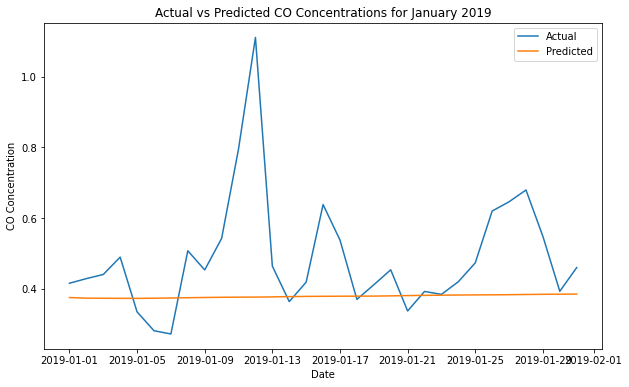

In [205]:
import matplotlib.pyplot as plt

# Extract the actual CO concentrations for the month of January 2019 from the test set
actual_values = scaler.inverse_transform(test)
actual_values = actual_values[(len(actual_values)-31):, 0]

# Concatenate the actual and predicted values
values = np.concatenate((actual_values.reshape(-1, 1), pred_seq), axis=1)

# Create a datetime index for the values
dates = pd.date_range(start='2019-01-01', end='2019-01-31', freq='D')

# Create a dataframe with the actual and predicted values and the datetime index
df = pd.DataFrame(values, index=dates, columns=['Actual', 'Predicted'])

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Actual'], label='Actual')
plt.plot(df.index, df['Predicted'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('CO Concentration')
plt.title('Actual vs Predicted CO Concentrations for January 2019')
plt.legend()
plt.show()